# Section 8.3 Lab: Decision Trees

## Fitting Classification Trees

In [4]:
library(ISLR)
library(tree)
library(magrittr)

Were are going to predict the *Sales* variable from `Carseats` dataset. *Sales* is a continuous variable so we begin by recording it as as a new binary variable called *High* with the `ifelse()` function, to assing the value of **Yes** i the *Sales* exceeds 8, and **No** otherwise.

In [ ]:
attach(Carseats)

In [ ]:
High = ifelse(Sales<=8, "No", "Yes")

In [ ]:
Carseats = data.frame(Carseats, High)
str(Carseats)

Now we use the `tree()` function to fit a classification tree in order to predict *High* using all the variables but *Sales*

In [ ]:
tree.carseats =  tree(High ~ . - Sales, Carseats)

In [ ]:
summary(tree.carseats)

We can see that the training erro rate is 9%. For classfication trees, the deviance reported in the output of summary() is given by :

$$
-2\sum_{m}\sum_{k}n_{mk}log\hat p_{mk}
$$

where $n_{mk}$ is the number of observations in the *m*th terminal node that belong to the *k*th class. A small deviance indicates a tree that provides a good fit to the (trainig) data. The *residual mean deviance* reported is simply the deviance divided by $n-|T_0|$.

In [ ]:
plot(tree.carseats)
text(tree.carseats, pretty = 0)

The most important indicator of *Sales* appears to be shelving location, since hte first branch differentiates **Good** locations from **Bad** and **Medium** locations.

If we just type the name of the tree object, *R* prints ouptut corresponding to each branch of the tree

In [ ]:
tree.carseats

*R* displays
* split criterion : 
* nº obs in that branch
* deviance
* overall prediction for the branch (**Yes** or **No**)
* fracto of obs in that branch that take values of **Yes** and **No**

Branches that lead to terminal nodes are indicates using asterisks.

In order to properly evaluate the performance of a classificatio tree on these data, we must estimate the test error rather than simply computing the trainig error.

In [ ]:
set.seed(2)
train = sample(1:nrow(Carseats),200)
Carseats.test = Carseats[-train,]
High.test = High[-train]
tree.carseats = tree(High ~ .-Sales, Carseats, subset = train)
tree.pred = predict(tree.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

In [ ]:
ACC_f = function(TN,TP,FN,FP){
    return( (TN + TP) / (TN+TP+FN+FP) )
}

In [ ]:
ACC_f(104,50,13,33)  %>% round(3)

This approach leads to correct predictions for around 77% fo the location in the test dataset

Next we considerer wheter prunning the tree might lead to improved results. The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity. We use the argument `FUN=prune.misclass` in order to indicate that we want the calssification error rate to guide the cross-validation and pruning process, rather than the default for `cv.tree()` which is deviance.

In [ ]:
set.seed(3)
cv.carseats = cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)


$k$ correspond to $\alpha$ in

$$
\sum_{m=1}^{|T|}{\sum_{i:x_i \in R_m}{(y_i - \hat y_{R_{m}})^2 + \alpha |T|}}
$$

where 
* $T\subset T_0$
* $T_0$ is the very large tree that needs to be pruned
* $|T|$ indicates the number of terminal nodes of the tree $T$
* $R_m$ is the rectangle (i.e the subset of predictor space) corresponding to the $m$th terminal node
* $\hat y_{R_{m}}$ os the predicted response associated with $R_m$ -that is the mean of the training obs in $R_m$


$\alpha$ is the tunning parameter that controls a trade-off between the subree's complexity and its fit to the training data

In [ ]:
cv.carseats

Note that the name `dev` corresponds to the cross-validation error rate in this instance. The tree with 21 terminal nodes result in the lowest cross-validation error rate, with 74 cross-validation errors

In [ ]:
par(mfrow = c(1,2))
plot(cv.carseats$size, cv.carseats$dev, type =  "b")
plot(cv.carseats$k, cv.carseats$dev, type =  "b")

We now apply the `prune.misclass()` function in order to prune the tree to obtain the 9 node tree.

In [ ]:
set.seed(3)
prune.carseats = prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

In [ ]:
set.seed(3)
tree.pred = predict(prune.carseats, Carseats.test, type  = "class")
table(tree.pred, High.test)

In [ ]:
ACC_f(103,52,14,31)

Now we have a slightly improved accuracy, but with a more interpretable tree. (29 vs 9 terminal nodes)

Now there is the prunned tree with only 2 terminal nodes: 

In [ ]:
prune.carseats = prune.misclass(tree.carseats, best = 2)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

tree.pred = predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

In [ ]:
ACC_f(104,27,13,56)

As expected the accuray is worse.

And finaly here is the tree with more terminal nodes than the chosen one (9) but with a similar accuracy.  

In [ ]:
prune.carseats = prune.misclass(tree.carseats, best = 14)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

tree.pred = predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

In [ ]:
ACC_f(102,52,15,31)

Hence we prefer the 9 nodes tree due to the better interpretability.

## Fitting Regression Trees

We are goint to use `Boston` dataset

In [1]:
library(MASS)

In [2]:
str(Boston)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


In [11]:
set.seed(1)
train = sample(1:nrow(Boston), nrow(Boston)/2)
tree.boston = tree(medv ~ ., Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

In the context of regression the deviance is simply the sum of squared errors for the tree.

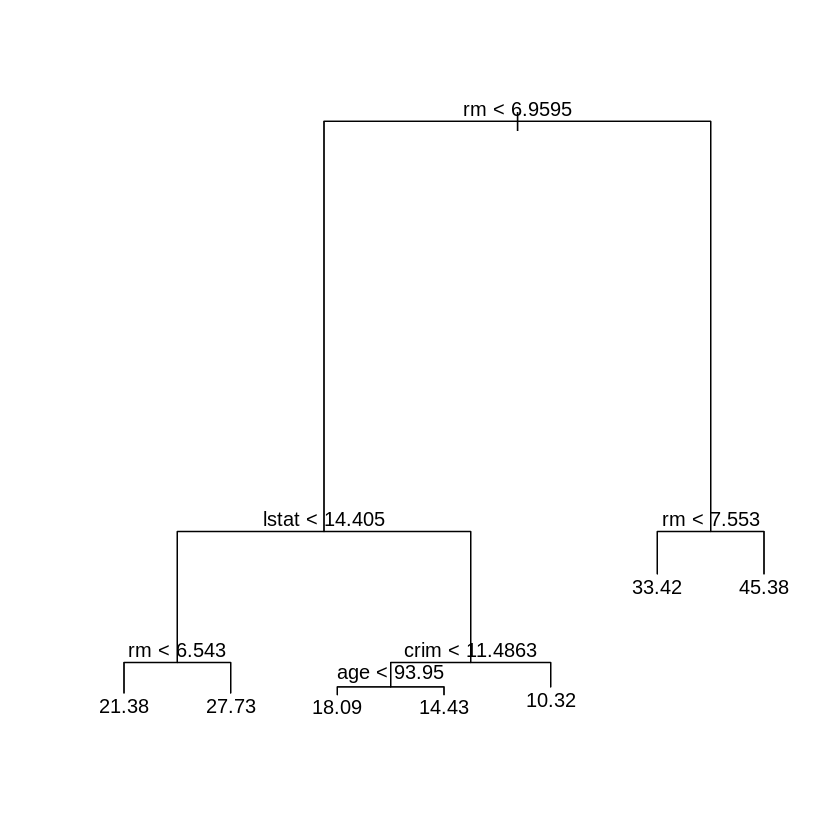

In [10]:
plot(tree.boston)
text(tree.boston, pretty = 0)

The most important variable is `rm` wich represents "average number of rooms per dwelling." The houses with less than 7 rooms, with a high `lstat` ("lower status of the population (percent)") and high crime have the more economic value. In the other side the houses with more than 7.5 rooms are the most expensive.

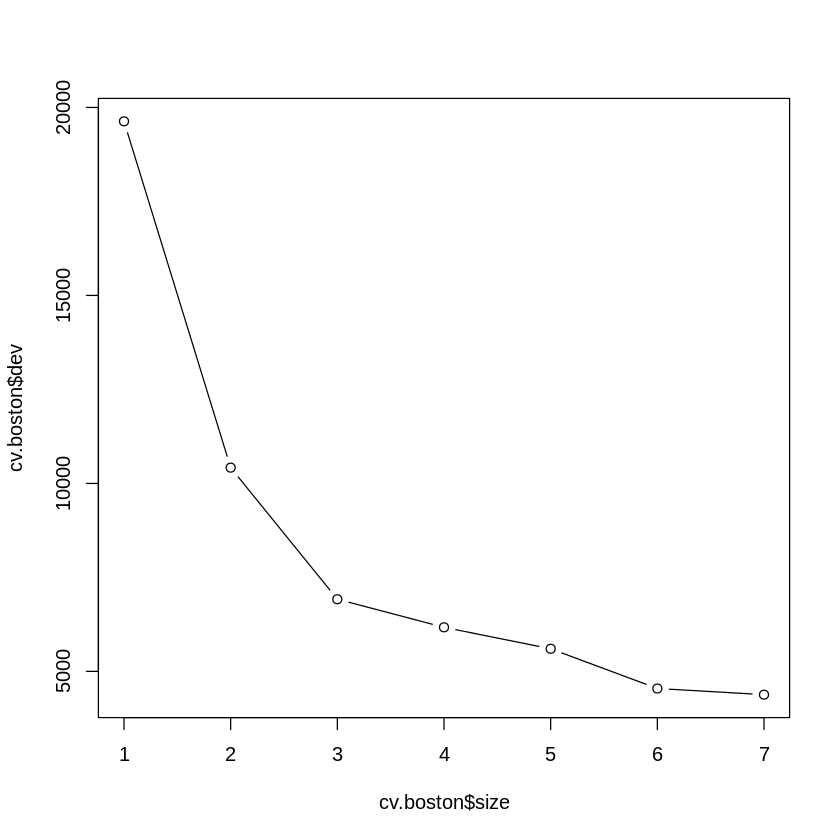

In [12]:
cv.boston = cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b")

In this case using the more complex tree is advised by cross-validation.

If we wish to prune the tree we could do as follows:

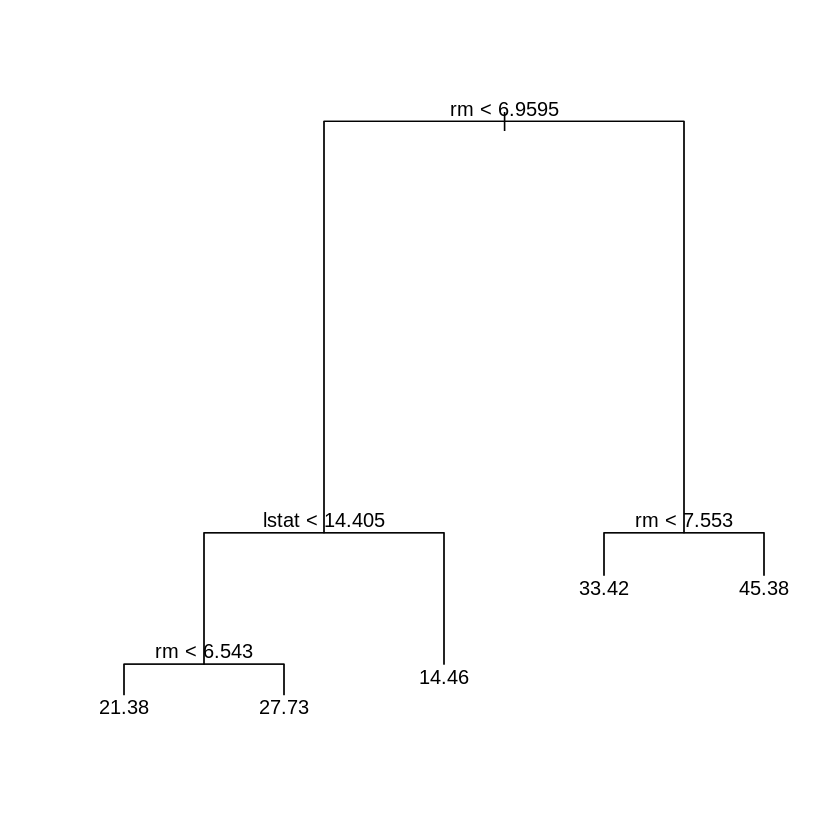

In [14]:
prune.boston = prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston)

Keeping with the cross-validation results we use the unpruned tree to make predictions on the test set.

[1] 35.287

[1] 5.94

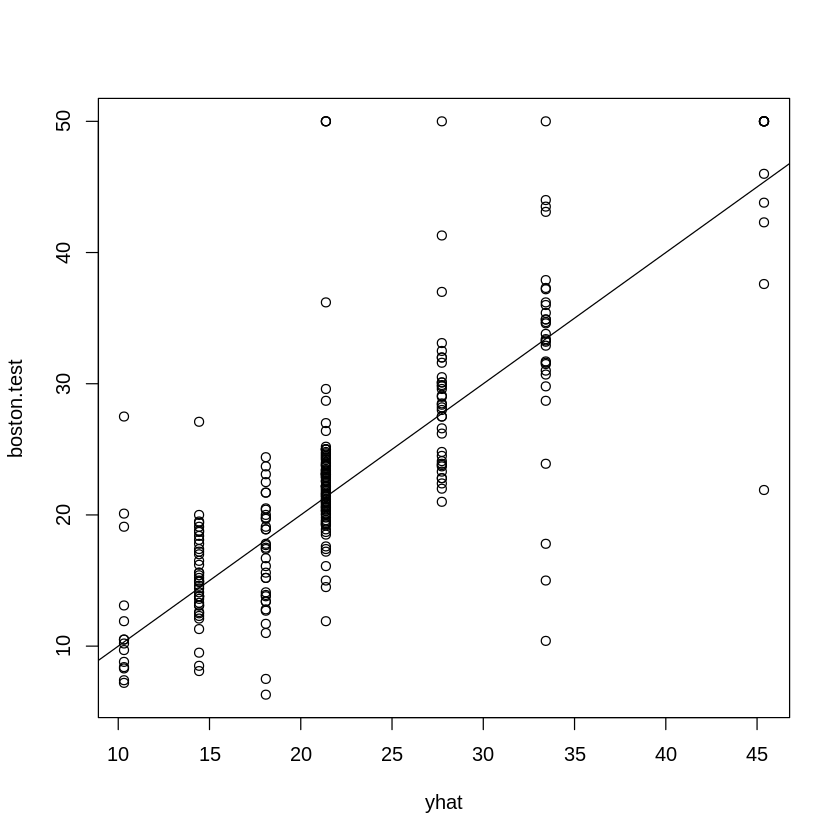

In [18]:
yhat = predict(tree.boston, newdata = Boston[-train,])
boston.test = Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0,1)
(MSE = mean((yhat-boston.test)^2))  %>% round(3)
(RMSE = sqrt(mean((yhat-boston.test)^2)))  %>% round(3)

 In other words, the test set MSE associated with the regression tree is 35.28, and the RMSE 5.9 indicating that this model leads to test set predictions that are within 6000$ of the true median home value for the suburb. 

## Bagging and Random Forests

Here we apply bagging and random forests to the Boston data, using the `randomForest` package in R.

Recall that baggin is simply a special case of random forest with $m=p$. Therefore the `randomForest()` function can be used to perform both random forests and bagging. We perform bagging as follows:

In [25]:
library(randomForest)
set.seed(1)
bag.boston = randomForest(medv ~ ., data = Boston, subset = train,
             mtry = 13, # all the 13 predictors should be considered
             importance = T)

Because $mtry = 13$, all the predictors are taken into account, in other words, bagging should be done.

[1] 23.593

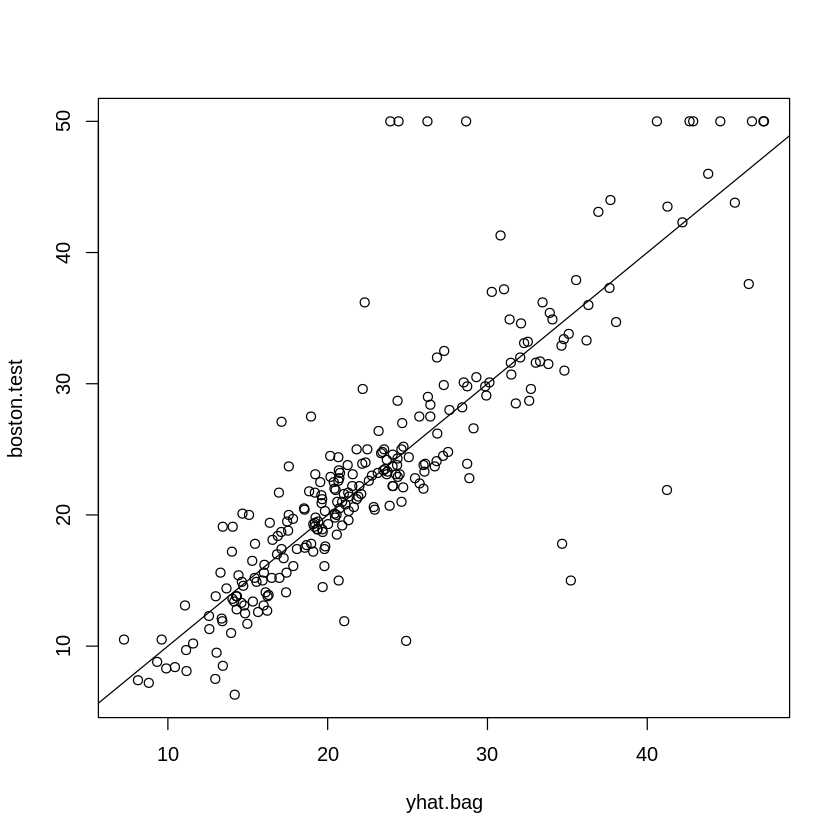

In [29]:
yhat.bag = predict(bag.boston, newdata = Boston[-train,])
plot(yhat.bag, boston.test)
abline(0,1)
mean((yhat.bag - boston.test)^2)  %>% round(3)

The test set MSE associated with the bagged regression tre is 23.6, 12 units less than using an optimally-pruned single tree.

We could change the number of tree grown by `randomForest()` using the `ntree` argument.

In [31]:
bag.boston = randomForest(medv ~ ., data = Boston,
                          subset = train,
                          mtry = 13,
                          ntree = 25)
yhat.bag = predict(bag.boston, newdata = Boston[-train,])
mean((yhat.bag - boston.test)^2)

[1] 23.45478

Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `mtry` argument. By default, `randomForest()` uses p/3 variables when building a random forest of regression of trees, and $\sqrt p$ variables when building a random forest of classification trees. Here we use `mtry = 6`.

In [36]:
set.seed(1)
rf.boston = randomForest(medv ~ ., data = Boston, subset = train,
                         mtry = 6, importance = T)
yhat.rf = predict(rf.boston, newdata = Boston[-train,])
mean((yhat.rf - boston.test)^2)  %>% round(3)

[1] 19.62

The test set is 19.5, this indicates that randoms forests yielded an improvement over bagging in this case.

Using the `importance()` we can view the importance of each variable

In [38]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,16.697017,1076.08786
zn,3.625784,88.35342
indus,4.968621,609.53356
chas,1.061432,52.21793
nox,13.518179,709.87339
rm,32.343305,7857.65451
age,13.272498,612.21424
dis,9.032477,714.94674
rad,2.878434,95.80598
tax,9.118801,364.92479


Two measures of variable imporance are reported:
* $\%incMSE$ : Based upon the mean decrease of the accuracy in predicitions on the out of bag samples when a given variable is excluded from the model.
* $IncNodePurity$ : Measure of total decrease in node purity that results from splits over that variable, averaged over all trees. In the case of regression trees, the node impurity is measured by the training RSS, and for classification trees by de deviance.

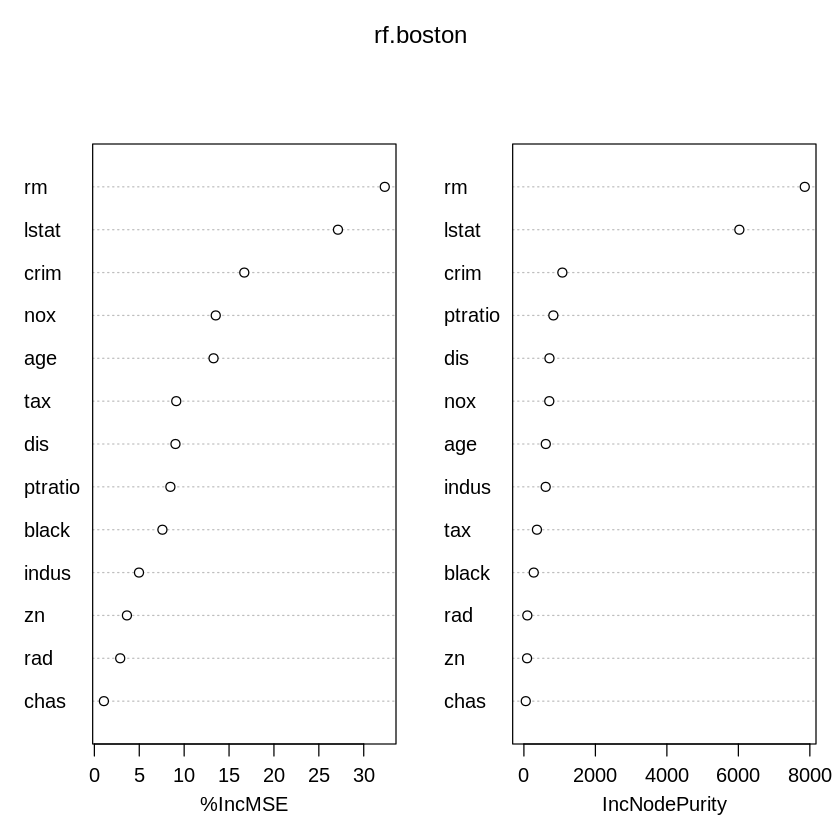

In [44]:
varImpPlot(rf.boston)

The results indicated that accross all fo the trees considered in the random forest, the number of rooms (****) and the wealth level of the comunity

